## Importing Library


In [2]:
# Import some libraries

import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
seed = 0
np.random.seed(seed)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'whitegrid')

import nest_asyncio
nest_asyncio.apply()


import datetime as dt
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

!pip install Sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from wordcloud import WordCloud

!pip install scikeras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Embedding, Dense, Dropout, LSTM, Bidirectional
from keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.model_selection import GridSearchCV
# from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

## Load Data 500 tweets about 'hewan peliharaan'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load data from a CSV file into pandas DataFrame
import pandas as pd
pd.options.mode.chained_assignment = None

tweets_data = pd.read_csv('./drive/MyDrive/500_data_tweet_hewan_peliharaan.csv', on_bad_lines='skip', sep=';', header=0)
tweets = tweets_data[['created_at', 'id_str', 'full_text', 'quote_count', 'reply_count', 'retweet_count', 'favorite_count', 'lang', 'user_id_str', 'conversation_id_str', 'username', 'tweet_url']]
tweets['full_text']

0      @alphacanismay0r @qrivasi @txtdrjkt Ya kalau n...
1      Ril ges. Emg mahal bet ngurusin hewan pelihara...
2      Kalau kamu bilang hewan ternak produktif mungk...
3      hi, ini oji. hewan peliharaan pertama treleven...
4      Kuy lagi ada diskon nih buat Cemilan Kucing Fo...
                             ...                        
512    @kegblgnunfaedh Buat kalian yg stres berlebih ...
513    Pengen bgt punya peliharaan, mending pelihara ...
514    ugm_fess smt 7 gabut bgt huhu, saran dong hewa...
515         (((rooftop untuk hewan peliharaan bermain)))
516    info hewan peliharaan yg maintenance nya mudah...
Name: full_text, Length: 517, dtype: object

### Function to Cleaning Text

In [ ]:
# Some functions for preprocessing text

def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # remove mentions
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # remove hashtag
    text = re.sub(r'RT[\s]', '', text) # remove RT
    text = re.sub(r"http\S+", '', text) # remove link
    text = re.sub(r'[0-9]+', '', text) # remove numbers

    text = text.replace('\n', ' ') # replace new line into space
    text = text.translate(str.maketrans('', '', string.punctuation)) # remove all punctuations
    text = text.strip(' ') # remove characters space from both left and right text
    return text

def casefoldingText(text): # Converting all the characters in a text into lower case
    text = text.lower()
    return text

def tokenizingText(text): # Tokenizing or splitting a string, text into a list of tokens
    text = word_tokenize(text)
    return text

def filteringText(text): # Remove stopwors in a text
    listStopwords = set(stopwords.words('indonesian'))
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

def stemmingText(text): # Reducing a word to its word stem that affixes to suffixes and prefixes or to the roots of words
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    text = [stemmer.stem(word) for word in text]
    return text

def toSentence(list_words): # Convert list of words into sentence
    sentence = ' '.join(word for word in list_words)
    return sentence

### Import Libary NLTK

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Preprocessing Data

In [ ]:
# Preprocessing tweets data

tweets['text_clean'] = tweets['full_text'].apply(cleaningText)
tweets['text_clean'] = tweets['text_clean'].apply(casefoldingText)
tweets.drop(['full_text'], axis = 1, inplace = True)

tweets['text_preprocessed'] = tweets['text_clean'].apply(tokenizingText)
tweets['text_preprocessed'] = tweets['text_preprocessed'].apply(filteringText)
tweets['text_preprocessed'] = tweets['text_preprocessed'].apply(stemmingText)

# drop duplicates/spams tweets
tweets.drop_duplicates(subset = 'text_clean', inplace = True)

# Export to csv file
tweets.to_csv(r'25k_tweets_data_clean.csv', index = False, header = True,index_label=None)

tweets

,created_at,id_str,quote_count,reply_count,retweet_count,favorite_count,lang,user_id_str,conversation_id_str,username,tweet_url,text_clean,text_preprocessed
0,Wed Oct 25 12:08:20 +0000 2023,1717151102490333666,0,0,0,0,in,1090560775947575296,1716654437438275662,Bastiancoks,https://twitter.com/Bastiancoks/status/1717151...,ya kalau niat baik buat ngerawat kucing liar h...,"[ya, niat, ngerawat, kucing, liar, modal, urus..."
1,Wed Oct 25 10:36:05 +0000 2023,1717127885876830232,0,1,0,0,in,68359088,1717127885876830232,bercuaca,https://twitter.com/bercuaca/status/1717127885...,ril ges emg mahal bet ngurusin hewan peliharaa...,"[ril, ges, emg, mahal, bet, ngurusin, hewan, p..."
2,Wed Oct 25 10:25:28 +0000 2023,1717125215896117631,0,0,0,0,in,837476723797045248,1717124601359274449,dustyblush,https://twitter.com/dustyblush/status/17171252...,kalau kamu bilang hewan ternak produktif mungk...,"[bilang, hewan, ternak, produktif, tuju, pelih..."
3,Wed Oct 25 10:21:10 +0000 2023,1717124133287571619,0,1,0,0,in,1496779912254193670,1717124133287571619,mistlhetoe,https://twitter.com/mistlhetoe/status/17171241...,hi ini oji hewan peliharaan pertama treleven,"[hi, oji, hewan, pelihara, treleven]"
4,Wed Oct 25 10:17:21 +0000 2023,1717123171474932006,0,0,0,0,in,1449928212465606662,1717123171474932006,bbyflufy,https://twitter.com/bbyflufy/status/1717123171...,kuy lagi ada diskon nih buat cemilan kucing fo...,"[kuy, diskon, nih, cemilan, kucing, food, gemu..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,Sun Oct 15 17:26:48 +0000 2023,1713607366560919991,0,0,0,0,in,1461351097461731330,1712440758761050552,Bebek99tt,https://twitter.com/Bebek99tt/status/171360736...,buat kalian yg stres berlebih gue saranin buat...,"[yg, stres, lebih, gue, saranin, hewan, peliha..."
513,Sun Oct 15 15:36:29 +0000 2023,1713579606681534873,0,8,0,2,in,1659924300856688640,1713579606681534873,honeyybaniswiti,https://twitter.com/honeyybaniswiti/status/171...,pengen bgt punya peliharaan mending pelihara h...,"[ken, bgt, pelihara, mending, pelihara, hewan,..."
514,Sun Oct 15 15:08:48 +0000 2023,1713572638994682329,3,20,0,41,in,1277749122296983552,1713572638994682329,UGM_FESS,https://twitter.com/UGM_FESS/status/1713572638...,ugmfess smt gabut bgt huhu saran dong hewan p...,"[ugmfess, smt, gabut, bgt, huhu, saran, hewan,..."
515,Sun Oct 15 14:44:06 +0000 2023,1713566422256042134,0,0,0,0,in,1149240203720024064,1713563925776879892,_sipelayan,https://twitter.com/_sipelayan/status/17135664...,rooftop untuk hewan peliharaan bermain,"[rooftop, hewan, pelihara, main]"


In [ ]:
tweets[['text_clean','text_preprocessed']]

,text_clean,text_preprocessed
0,ya kalau niat baik buat ngerawat kucing liar h...,"[ya, niat, ngerawat, kucing, liar, modal, urus..."
1,ril ges emg mahal bet ngurusin hewan peliharaa...,"[ril, ges, emg, mahal, bet, ngurusin, hewan, p..."
2,kalau kamu bilang hewan ternak produktif mungk...,"[bilang, hewan, ternak, produktif, tuju, pelih..."
3,hi ini oji hewan peliharaan pertama treleven,"[hi, oji, hewan, pelihara, treleven]"
4,kuy lagi ada diskon nih buat cemilan kucing fo...,"[kuy, diskon, nih, cemilan, kucing, food, gemu..."
...,...,...
512,buat kalian yg stres berlebih gue saranin buat...,"[yg, stres, lebih, gue, saranin, hewan, peliha..."
513,pengen bgt punya peliharaan mending pelihara h...,"[ken, bgt, pelihara, mending, pelihara, hewan,..."
514,ugmfess smt gabut bgt huhu saran dong hewan p...,"[ugmfess, smt, gabut, bgt, huhu, saran, hewan,..."
515,rooftop untuk hewan peliharaan bermain,"[rooftop, hewan, pelihara, main]"


In [ ]:
# Because preprocessing tweets data takes a lot time, so I load tweets data which has been preprocessed before
tweets = pd.read_csv('./25k_tweets_data_clean.csv')

for i, text in enumerate(tweets['text_preprocessed']):
    tweets['text_preprocessed'][i] = tweets['text_preprocessed'][i].replace("'", "")\
                                            .replace(',','').replace(']','').replace('[','')
    list_words=[]
    for word in tweets['text_preprocessed'][i].split():
        list_words.append(word)

    tweets['text_preprocessed'][i] = list_words

tweets['text_preprocessed']

0      [ya, niat, ngerawat, kucing, liar, modal, urus...
1      [ril, ges, emg, mahal, bet, ngurusin, hewan, p...
2      [bilang, hewan, ternak, produktif, tuju, pelih...
3                   [hi, oji, hewan, pelihara, treleven]
4      [kuy, diskon, nih, cemilan, kucing, food, gemu...
                             ...                        
493    [yg, stres, lebih, gue, saranin, hewan, peliha...
494    [ken, bgt, pelihara, mending, pelihara, hewan,...
495    [ugmfess, smt, gabut, bgt, huhu, saran, hewan,...
496                     [rooftop, hewan, pelihara, main]
497    [info, hewan, pelihara, yg, maintenance, nya, ...
Name: text_preprocessed, Length: 498, dtype: object

## Determine Sentiment Polarity of Tweets with Indonesia Sentiment Lexicon

In [ ]:
import csv

lexicon_positive = dict()
with open('./positive.csv', 'r') as f:
    reader = csv.DictReader(f)
    for row in reader:
        lexicon_positive[row['word']] = int(row['weight'])

In [ ]:
print(type(lexicon_positive))

<class 'dict'>


In [ ]:
# Determine sentiment polarity of tweets using indonesia sentiment lexicon (source : https://github.com/fajri91/InSet)

# Loads lexicon positive and negative data

lexicon_positive = dict()
import csv
with open('./positive.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    header = next(reader)
    # lexicon_positive = [[row[0], int(row[1])] for row in reader if row]
    for row in reader:
        lexicon_positive[row[0]] = int(row[1])

lexicon_negative = dict()
import csv
with open('./negative.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    header = next(reader)
    # lexicon_negative = [[row[0], int(row[1])] for row in reader if row]
    for row in reader:
        lexicon_negative[row[0]] = int(row[1])

# Function to determine sentiment polarity of tweets
def sentiment_analysis_lexicon_indonesia(text):
    #for word in text:
    score = 0
    for word in text:
        if (word in lexicon_positive):
            score = score + lexicon_positive[word]
    for word in text:
        if (word in lexicon_negative):
            score = score + lexicon_negative[word]
    polarity=''
    if (score >= 0):
        polarity = 'positive'
    else:
        polarity = 'negative'

    return score, polarity

In [ ]:
# Results from determine sentiment polarity of tweets

results = tweets['text_preprocessed'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
tweets['polarity_score'] = results[0]
tweets['polarity'] = results[1]
print(tweets['polarity'].value_counts())

# Export to csv file
# tweets.to_csv(r'25k_tweets_data_clean_polarity.csv', index = False, header = True,index_label=None)

tweets

positive    327
negative    171
Name: polarity, dtype: int64


,created_at,id_str,quote_count,reply_count,retweet_count,favorite_count,lang,user_id_str,conversation_id_str,username,tweet_url,text_clean,text_preprocessed,polarity_score,polarity
0,Wed Oct 25 12:08:20 +0000 2023,1717151102490333666,0,0,0,0,in,1090560775947575296,1716654437438275662,Bastiancoks,https://twitter.com/Bastiancoks/status/1717151...,ya kalau niat baik buat ngerawat kucing liar h...,"[ya, niat, ngerawat, kucing, liar, modal, urus...",8,positive
1,Wed Oct 25 10:36:05 +0000 2023,1717127885876830232,0,1,0,0,in,68359088,1717127885876830232,bercuaca,https://twitter.com/bercuaca/status/1717127885...,ril ges emg mahal bet ngurusin hewan peliharaa...,"[ril, ges, emg, mahal, bet, ngurusin, hewan, p...",5,positive
2,Wed Oct 25 10:25:28 +0000 2023,1717125215896117631,0,0,0,0,in,837476723797045248,1717124601359274449,dustyblush,https://twitter.com/dustyblush/status/17171252...,kalau kamu bilang hewan ternak produktif mungk...,"[bilang, hewan, ternak, produktif, tuju, pelih...",2,positive
3,Wed Oct 25 10:21:10 +0000 2023,1717124133287571619,0,1,0,0,in,1496779912254193670,1717124133287571619,mistlhetoe,https://twitter.com/mistlhetoe/status/17171241...,hi ini oji hewan peliharaan pertama treleven,"[hi, oji, hewan, pelihara, treleven]",4,positive
4,Wed Oct 25 10:17:21 +0000 2023,1717123171474932006,0,0,0,0,in,1449928212465606662,1717123171474932006,bbyflufy,https://twitter.com/bbyflufy/status/1717123171...,kuy lagi ada diskon nih buat cemilan kucing fo...,"[kuy, diskon, nih, cemilan, kucing, food, gemu...",9,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,Sun Oct 15 17:26:48 +0000 2023,1713607366560919991,0,0,0,0,in,1461351097461731330,1712440758761050552,Bebek99tt,https://twitter.com/Bebek99tt/status/171360736...,buat kalian yg stres berlebih gue saranin buat...,"[yg, stres, lebih, gue, saranin, hewan, peliha...",-6,negative
494,Sun Oct 15 15:36:29 +0000 2023,1713579606681534873,0,8,0,2,in,1659924300856688640,1713579606681534873,honeyybaniswiti,https://twitter.com/honeyybaniswiti/status/171...,pengen bgt punya peliharaan mending pelihara h...,"[ken, bgt, pelihara, mending, pelihara, hewan,...",13,positive
495,Sun Oct 15 15:08:48 +0000 2023,1713572638994682329,3,20,0,41,in,1277749122296983552,1713572638994682329,UGM_FESS,https://twitter.com/UGM_FESS/status/1713572638...,ugmfess smt gabut bgt huhu saran dong hewan p...,"[ugmfess, smt, gabut, bgt, huhu, saran, hewan,...",-4,negative
496,Sun Oct 15 14:44:06 +0000 2023,1713566422256042134,0,0,0,0,in,1149240203720024064,1713563925776879892,_sipelayan,https://twitter.com/_sipelayan/status/17135664...,rooftop untuk hewan peliharaan bermain,"[rooftop, hewan, pelihara, main]",3,positive


In [ ]:
tweets.to_csv(r'500_tweets_data_clean_polarity.csv', index = False, header = True,index_label=None)

## Analysis and Visualization

## Comparasion Sentiment Polarity on Tweets Data

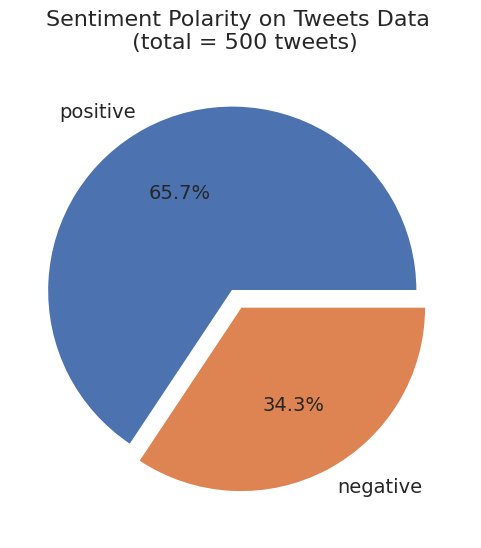

In [ ]:
fig, ax = plt.subplots(figsize = (6, 6))
sizes = [count for count in tweets['polarity'].value_counts()]
labels = list(tweets['polarity'].value_counts().index)
explode = (0.1, 0)
ax.pie(x = sizes, labels = labels, autopct = '%1.1f%%', explode = explode, textprops={'fontsize': 14})
ax.set_title('Sentiment Polarity on Tweets Data \n (total = 500 tweets)', fontsize = 16, pad = 20)
plt.show()

## Top 10 Positive and Negative Tweet Sentiments

In [ ]:
pd.set_option('display.max_colwidth', 3000)
positive_tweets = tweets[tweets['polarity'] == 'positive']
positive_tweets = positive_tweets[['text_clean', 'polarity_score', 'polarity']].sort_values(by = 'polarity_score', ascending=False).reset_index(drop = True)
positive_tweets.index += 1
positive_tweets[0:10]

,text_clean,polarity_score,polarity
1,enak banget ya punya binatang peliharaan beli sendiri kemauan sendiri tapi maunya maintenance kesehatan dibayarin pemerintah gahabis pikir kalo negara kita terbuat dari emas murni sih gapapa setuju gue jg ini bpjs aja masih blm maksimal udh bpjs hewan aja lo ajuin wkkw,23,positive
2,nemu promo menarik di lazada nih yuk coba lihat nama produk petko cemilan kucing food penggemuk murah kitten kering penggemuk box snack hewan peliharaan kecil cat strip gr harga produk rp harga diskon rp,20,positive
3,aku nemu promo menarik di lazada nih yuk coba lihat nama produk cemilan kucing food penggemuk murah kitten kering penggemuk box snack hewan peliharaan kecil cat strip grstrip creamy harga produk rp harga diskon rp,20,positive
4,longbaobao setuju sih kak aku juga cat lover dan menurutku program bpjs atau serupa buat hewan peliharaan ga penting amat ya balik lagi kalo ga mampu pelihara ga usah pelihara anabul dan kalo pelihara anabul ya harus siap dana darurat kalo sewaktu ada masalah kesehatan anabul,20,positive
5,setuju sih hewan peliharaan itu termasuk tersier yg kalo mau ya pelihara kalo gak mau ya gada efek apa kalo soal bpjs ke hewan mending di fokuskan ke hewan ternak dan juga satwa liar sekalipun ke anabul ya yg di shelter bukan ke anabul yg punya owner,20,positive
6,membahas kucing adalah mahluk yg selalu bersholawat pada tuannya yg memelihara ia jinak dan bisa membuat pemiliknya nyaman saya penyayang binatang karena mereka mahluk allah jadi tidak pantas saya di sejajarkan hewan peliharaan kecuali orang yg munafik,18,positive
7,demi allah i was shaking and trembling so hard when he started to explain the meaning of “ruby” 😭 gue pernah baca dmn gitu kalo hewan peliharaan kita itu ada “masa”nya… gue takut bgt kalo nnt harus pisah sm zuko… dia beneran nemenin gue di masa susah ini ya allah ga sanggup,17,positive
8,hewan peliharaan memiliki lebih banyak cinta dan kasih sayang daripada kebanyakan manusia wahh para pecinta kucing sini merapat yuk kita lihat anies baswedan punya kucing apa ajaaa checkidot 👇👇👇 anies penyayang,17,positive
9,ciriciri orang yang hidupnya ga sehat bangun tidur langsung bales wa berarti dia ga langsung take care of themselves apalagi minggu enaknya ya sibuk sama diri sendiri keluarga atau hewan peliharaan ketimbang bales wa orang baru dikenal kalo gue langsung gue ulti si nder,17,positive
10,beneran ka tapikan semua tergantung kepercayaan masing” sebenrnya bukan kucing aja ikan juga bisa pokonya yang kita pelihara di rumah kalo ga ada hewan peliharaan di rumah otomatis kena ke orangnya langsung karna ga ada penangkalnya ka,16,positive


In [ ]:
pd.set_option('display.max_colwidth', 3000)
negative_tweets = tweets[tweets['polarity'] == 'negative']
negative_tweets = negative_tweets[['text_clean', 'polarity_score', 'polarity']].sort_values(by = 'polarity_score', ascending=True)[0:10].reset_index(drop = True)
negative_tweets.index += 1
negative_tweets[0:10]

,text_clean,polarity_score,polarity
1,buat gue yg pecinta hewan jjr gue ga tega sistem gue musuh ma kecowa sama uler intinya hewan yg serangga tapi kalo kek hewan berbulu dan apalagi hewan nya baik kyk hewan peliharaan gak tega bgt buat bunuh dan gak suka kalo ada yg nyakitin selama gak serang yg jngn di bunuh,-33,negative
2,hewan peliharaan pet itu katogori tersier waktu pelajaran ips di sd kan sudah diajarin mana kebutuhan primer sekunder tersier hewan ternak seperti sapi kambing domba kerbau ayam bebek entog dll lebih butuh keringanan biaya karena menyangkut pangan,-27,negative
3,masih banyak rakyat miskin yg makan aja susah ga punya tempat tinggal layak dll kl ga mampu bayar biaya berobat hewan peliharaan ya jangan punya hewan peliharaan prinsip punya hewan tuh mirip kyk punya anak kl tau ga mampu bayar kebutuhan mereka mending ga punya sekalian,-21,negative
4,bodoamat dah lo mau kucing anjing capung badak macan atau apa kek ya tapi jangan sampe ganggu ketenangan orang anjing😡 tiap hari gue bangun buka jendela bukannya seger malah bau tai hewan peliharaan lo itu monyet,-20,negative
5,gui ngasih hewan peliharaan itu ibarat nyuruh rui buat jaga sesuatu dari dia jangan mikirin harganya tapi artinya ngurus hewan juga butuh kata serius ga tau dari kapan gui nyisihin uangnya yang pasti ini anak udah mikirin dari lama,-20,negative
6,🐣 nah iya boleh tu yg gua baru tau hamster gaboleh dibeli 🐶 kenapa tuh 🐣 masih satu famili sama tikus dia tuh kan hewat pengerat 🐶 emang gimana si yg gabisa dimakan tu yg gaboleh dipelihara 🐣 gabole beli hewan peliharaan yg gabisa dimakan ko jadi njelimet ceritanya😌,-18,negative
7,🐶 ohh baru tau gua kayak yg masalah hewan peliharaan itu tuh baru gua juga yg gabisa dimakan gaboleh dibeli kalo kuda berarti gaboleh ya kan gadimakan 🐣 😌 kuda bisa gasi kan ada yg jual 🐶 unta 🐣 boleh 🐶 ayam 🐣 kan lu makan ayam 😌 🐶 ehiya kelinci boleh yaa,-18,negative
8,lo pernah ga kehilangan hewan peliharaan sakitnya sakit bgtt sedihnya sedih bgt😭😭😭😭😭😭🥺🥺🥺🥺,-18,negative
9,cek hus hus ml kucing anti buang kotoran sembarangan pengusir tikus rat cat repellent disinfectant anti tikus kucing anti spraying aman untuk hewan peliharaan dan manusia dengan harga rp dapatkan di shopee sekarang,-17,negative
10,hewan peliharaan tetangga buang air di halaman kita bagaimana hukumnya kalau sampai hewan peliharaan masuk bahkan mengotori halaman rumah tetangga misalnya dengan membuang kotoran sembarangan apakah pemiliknya bisa dituntut gt gt,-17,negative


## Word Cloud

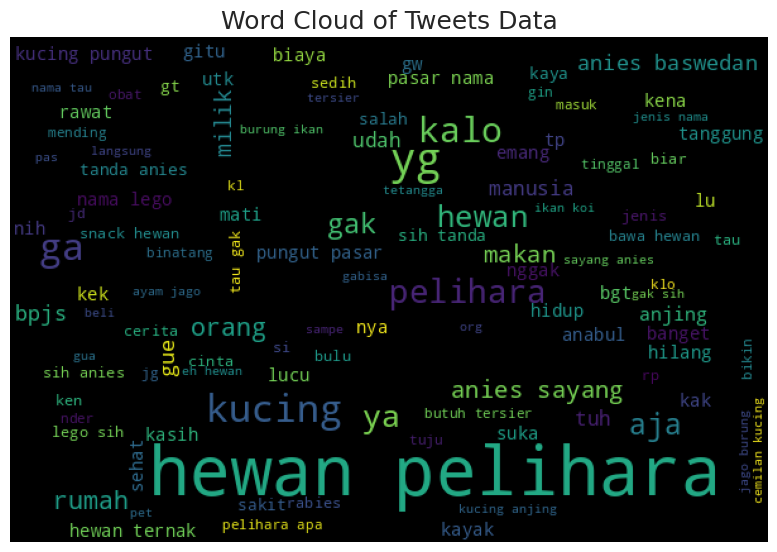

In [ ]:
# Visualize word cloud

list_words=''
for tweet in tweets['text_preprocessed']:
    for word in tweet:
        list_words += ' '+(word)

wordcloud = WordCloud(width = 600, height = 400, background_color = 'black', min_font_size = 10).generate(list_words)
fig, ax = plt.subplots(figsize = (8, 6))
ax.set_title('Word Cloud of Tweets Data', fontsize = 18)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')
plt.show()

## Positive and Negative Word Cloud

In [ ]:
# Function to group all positive/negative words
def words_with_sentiment(text):
    positive_words=[]
    negative_words=[]
    for word in text:
        score_pos = 0
        score_neg = 0
        if (word in lexicon_positive):
            score_pos = lexicon_positive[word]
        if (word in lexicon_negative):
            score_neg = lexicon_negative[word]

        if (score_pos + score_neg > 0):
            positive_words.append(word)
        elif (score_pos + score_neg < 0):
            negative_words.append(word)

    return positive_words, negative_words

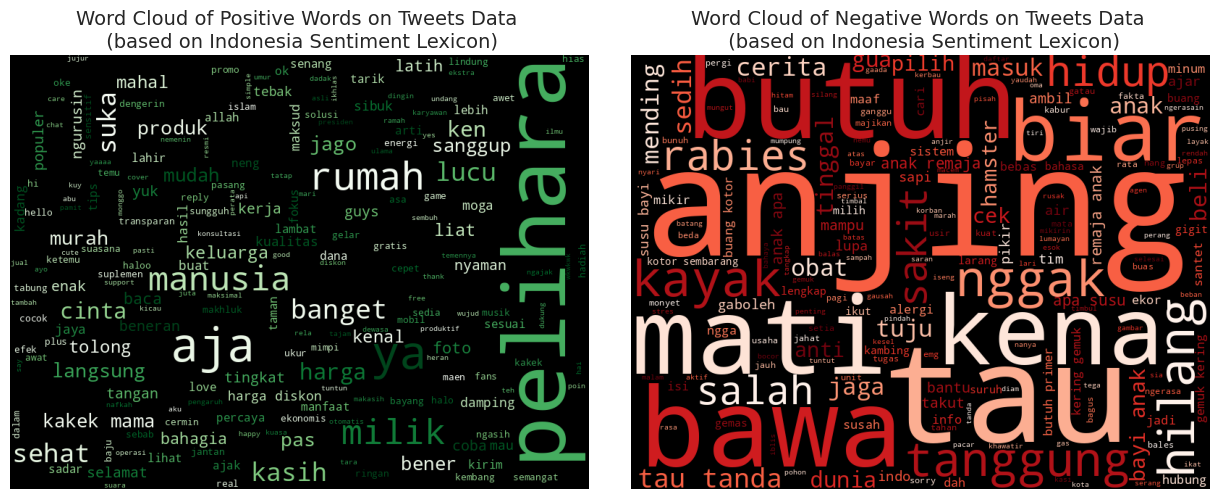

In [ ]:
# Visualize positive and negative word cloud

sentiment_words = tweets['text_preprocessed'].apply(words_with_sentiment)
sentiment_words = list(zip(*sentiment_words))
positive_words = sentiment_words[0]
negative_words = sentiment_words[1]

fig, ax = plt.subplots(1, 2,figsize = (12, 10))
list_words_postive=''
for row_word in positive_words:
    for word in row_word:
        list_words_postive += ' '+(word)
wordcloud_positive = WordCloud(width = 800, height = 600, background_color = 'black', colormap = 'Greens'
                               , min_font_size = 10).generate(list_words_postive)
ax[0].set_title('Word Cloud of Positive Words on Tweets Data \n (based on Indonesia Sentiment Lexicon)', fontsize = 14)
ax[0].grid(False)
ax[0].imshow((wordcloud_positive))
fig.tight_layout(pad=0)
ax[0].axis('off')

list_words_negative=''
for row_word in negative_words:
    for word in row_word:
        list_words_negative += ' '+(word)
wordcloud_negative = WordCloud(width = 800, height = 600, background_color = 'black', colormap = 'Reds'
                               , min_font_size = 10).generate(list_words_negative)
ax[1].set_title('Word Cloud of Negative Words on Tweets Data \n (based on Indonesia Sentiment Lexicon)', fontsize = 14)
ax[1].grid(False)
ax[1].imshow((wordcloud_negative))
fig.tight_layout(pad=0)
ax[1].axis('off')

plt.show()

## Counts of Tweets Created based on Hours

In [ ]:
# Visualize counts of tweets created based on hours

pd.plotting.register_matplotlib_converters()
tweets_created = pd.DataFrame()
tweets_created['created_at'] = tweets['created_at'].str.split(' ', expand = True)[1]
tweets_created['created_at'] = pd.to_datetime(tweets_created['created_at'])
tweets_created['created_at']= tweets_created['created_at'].dt.round('H')
tweets_created['created_at'] = tweets_created['created_at'].dt.time
tweets_created

fig, ax = plt.subplots(figsize = (12, 4))
x_values = tweets_created['created_at'].value_counts().sort_index().index
y_values = tweets_created['created_at'].value_counts().sort_index()
sns.lineplot(ax = ax, data = tweets, x = x_values, y = y_values)
ax.set_title('Count of Tweets Created \n (based on hours)', fontsize = 18)
ax.set_xlabel('Hours')
ax.set_xticks(x_values)
ax.set_xticklabels(x_values, rotation = 45)
ax.set_ylabel('Count')
plt.show()

OutOfBoundsDatetime: ignored

# Sentiment Analysis Using LSTM

## Preprocessing Text Data

In [ ]:
# Make text preprocessed (tokenized) to untokenized with toSentence Function
X = tweets['text_preprocessed'].apply(toSentence)
max_features = 8000

# Tokenize text with specific maximum number of words to keep, based on word frequency
tokenizer = Tokenizer(num_words=max_features, split=' ', oov_token='<OOV>')
tokenizer.fit_on_texts(X.values)
X = tokenizer.texts_to_sequences(X.values)
X = pad_sequences(X, padding='post')
X.shape

(498, 41)

In [ ]:
X

array([[  12,  832,  335, ...,    0,    0,    0],
       [ 834,  835,  336, ...,    0,    0,    0],
       [ 149,    2,   37, ...,    0,    0,    0],
       ...,
       [2198, 2199, 2200, ...,    0,    0,    0],
       [2204,    2,    3, ...,    0,    0,    0],
       [ 211,    2,    3, ...,    0,    0,    0]], dtype=int32)

In [ ]:
# Encode target data into numerical values
polarity_encode = {'negative' : 0, 'positive' : 1}
y = tweets['polarity'].map(polarity_encode).values

# Split the data (with composition data train 80%, data test 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(398, 41) (398,)
(100, 41) (100,)


## Model LSTM

In [ ]:
# Create model function with default hyperparameter values
def create_model(embed_dim = 16, hidden_unit = 16, dropout_rate = 0.2, optimizers = Adam, learning_rate = 0.001):
    model = Sequential()
    model.add(Embedding(input_dim = max_features, output_dim = embed_dim, input_length = X_train.shape[1]))
    model.add(Bidirectional(LSTM(units = hidden_unit)))
    # model.add(Bidirectional(LSTM(units = 32)))
    # model.add(Dropout(dropout_rate))
    # model.add(Dense(units = 32))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units = 16))
    model.add(Dense(units = 1, activation = 'sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer = optimizers(learning_rate = learning_rate), metrics = ['accuracy'])
    print(model.summary())
    return model

In [ ]:
# Create the model with the best hyperparameter which has been determined
model = KerasClassifier(build_fn = create_model,
                        # Model Parameters
                        dropout_rate = 0.2,
                        embed_dim = 32,
                        hidden_unit = 16,
                        optimizers = Adam,
                        learning_rate = 0.001,

                        # Fit Parameters
                        epochs=50,
                        batch_size=128,
                        # Initiate validation data, which is 10% data from data train. It's used for evaluation model
                        validation_split = 0.1)


model_prediction = model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 41, 32)            256000    
                                                                 
 bidirectional (Bidirection  (None, 32)                6272      
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 262817 (1.00 MB)
Trainable params: 262817 (1.00 MB)
Non-trainable params: 0 (0.00 Byte)
____________________

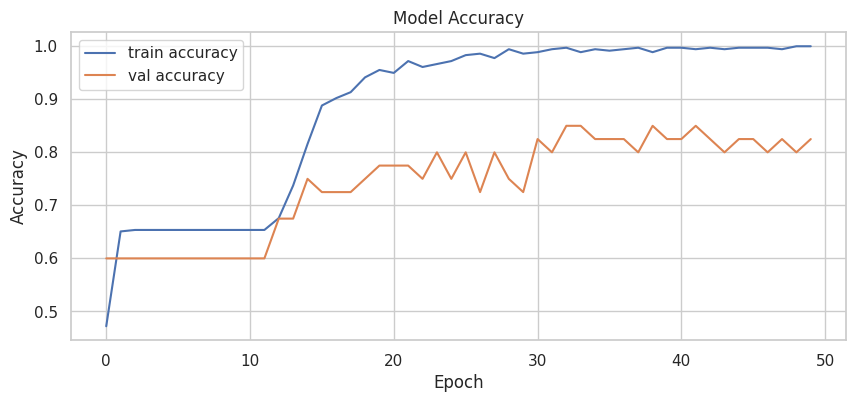

In [ ]:
# Visualization model accuracy (train and val accuracy)

fig, ax = plt.subplots(figsize = (10, 4))
ax.plot(model_prediction.history_['accuracy'], label = 'train accuracy')
ax.plot(model_prediction.history_['val_accuracy'], label = 'val accuracy')
ax.set_title('Model Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend(loc = 'upper left')
plt.show()

1/1 [==============================] - 1s 785ms/step
Model Accuracy on Test Data: 0.73


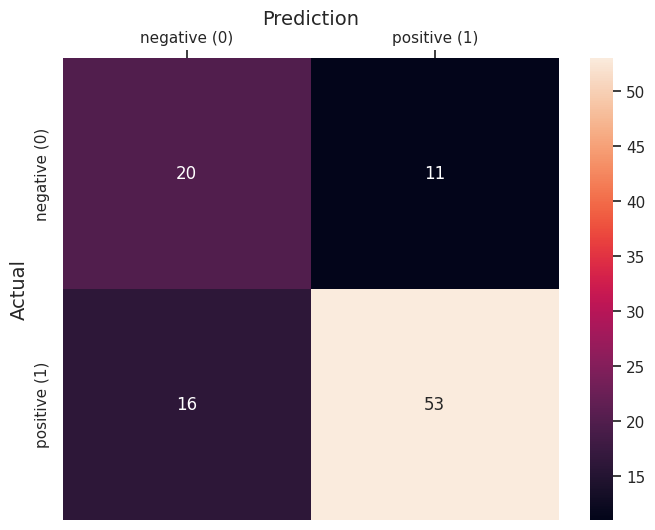

In [ ]:
# Predict sentiment on data test by using model has been created, and then visualize a confusion matrix


y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Model Accuracy on Test Data:', accuracy)
confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize = (8,6))
sns.heatmap(confusion_matrix(y_true = y_test, y_pred = y_pred), fmt = 'g', annot = True)
ax.xaxis.set_label_position('top')
ax.xaxis.set_ticks_position('top')
ax.set_xlabel('Prediction', fontsize = 14)
ax.set_xticklabels(['negative (0)', 'positive (1)'])
ax.set_ylabel('Actual', fontsize = 14)
ax.set_yticklabels(['negative (0)', 'positive (1)'])
plt.show()

In [ ]:
# Results from prediction sentiment on data test
text_clean = tweets['text_clean']
text_train, text_test = train_test_split(text_clean, test_size = 0.2, random_state = 0)
result_test = pd.DataFrame(data = zip(text_test, y_pred), columns = ['text', 'polarity'])
polarity_decode = {0 : 'Negative', 1 : 'Positive'}
result_test['polarity'] = result_test['polarity'].map(polarity_decode)
pd.set_option('max_colwidth', 300)
result_test

,text,polarity
0,kasi makan hewan peliharaan,Positive
1,boleh gw culik hewan peliharaan lu yang gembul itu,Positive
2,ᅠᅠ sejak zaman sm orang mesir kuno telah menggunakan kucing untuk menjauhkan tikus atau hewan pengerat lain dari lumbung yang menyimpan hasil panen saat ini kucing adalah salah satu hewan peliharaan terpopuler di dunia ᅠᅠ,Negative
3,tau gak sih’ anies baswedan punya hewan peliharaan berupa kucing yang ia pungut di pasar dan diberi nama lego waktu yang dihabiskan dengan kucing tidak pernah siasia ini sih tanda kalau anies penyayang,Negative
4,ataru botol cairan spray pet ml transparan botol semprot praktis untuk hewan peliharaan 🐱🌊 🔗 gibran skck gofud madura mom sorry imroatus path mamat dora,Negative
...,...,...
95,hewan peliharaan aku,Positive
96,garagara gw udah sayang bgt sama kucing gw juga jadi sayang ama binatang peliharaan yang lain misalnya anjing😭 gabisa bgt gw klo liat hewan itu disiksa atau meninggal,Positive
97,hewan peliharaan tidak hanya menggantikan hubungan manusia anies baswedan memungut kucing di sebuah pasar dalam kondisi kakinya yang rusak satu kucing tersebut akhirnya harus diamputasi dan kini hanya berkaki tiga 🥺🥺 anies penyayang,Positive
98,rutinitas kalo punya peliharaan hewan baru nieh ☺✨,Positive


## Predict with Other Data

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Initializing and preprocessing new text data
otherData = pd.DataFrame()
# otherData['text'] = ['kucing ku kok malas buat jalan-jalan ya',
#                      'hewan peliharaan ku kok sering lari ketakutan kalau lihat air'
#                     ]
otherData['text'] = ['Anjingku sakit, cidera, nangis karena kecelakaan',
                     'Malas, banget kucingku sakit jiwa, gila pusing banget'
                     ]

otherData['text_clean'] = otherData['text'].apply(cleaningText)
otherData['text_clean'] = otherData['text_clean'].apply(casefoldingText)
otherData.drop(['text'], axis = 1, inplace = True)

otherData['text_preprocessed'] = otherData['text_clean'].apply(tokenizingText)
otherData['text_preprocessed'] = otherData['text_preprocessed'].apply(filteringText)
otherData['text_preprocessed'] = otherData['text_preprocessed'].apply(stemmingText)
otherData

,text_clean,text_preprocessed
0,anjingku sakit cidera nangis karena kecelakaan,"[anjing, sakit, cidera, nang, celaka]"
1,malas banget kucingku sakit jiwa gila pusing banget,"[malas, banget, kucing, sakit, jiwa, gila, pusing, banget]"


In [ ]:
# Preprocessing text data

# Make text preprocessed (tokenized) to untokenized with toSentence Function
X_otherData = otherData['text_preprocessed'].apply(toSentence)
X_otherData = tokenizer.texts_to_sequences(X_otherData.values)
X_otherData = pad_sequences(X_otherData, maxlen = X.shape[1], padding='post')
X_otherData

array([[ 21,  74,   1, 390,   1,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  1,  42,   4,  74, 807,   1, 695,  42,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0]], dtype=int32)

In [ ]:
# Results from prediction sentiment on text data

y_pred_otherData = model.predict(X_otherData)
otherData['Result Prediction'] = y_pred_otherData

polarity_decode = {0 : 'Negative', 1 : 'Positive',}
otherData['Result Prediction'] = otherData['Result Prediction'].map(polarity_decode)
otherData

1/1 [==============================] - 0s 23ms/step


,text_clean,text_preprocessed,Result Prediction
0,anjingku sakit cidera nangis karena kecelakaan,"[anjing, sakit, cidera, nang, celaka]",Positive
1,malas banget kucingku sakit jiwa gila pusing banget,"[malas, banget, kucing, sakit, jiwa, gila, pusing, banget]",Positive


In [ ]:
#Percentage
y_pred = model.predict_proba(X_otherData)
y_pred

1/1 [==============================] - 0s 24ms/step


array([[0.4501621 , 0.5498379 ],
       [0.01895058, 0.9810494 ]], dtype=float32)